This notebook exercises some utility functions to load and explore the data.
It assumes that you have downloaded the training data and placed it in a *data* directory at the top of the repository.

We will use both plotly and matplotlib for displaying plots, charts and images.

In [1]:
import sys, os

sys.path.append("..")
import planet.util

import plotly
plotly.offline.init_notebook_mode(connected=True)

import matplotlib
import matplotlib.pyplot as plt

import numpy

First we define the data paths.

In [2]:
data_dir = "../data"
train_tags_path = os.path.join(data_dir, "train_v2.csv")
train_images_path = os.path.join(data_dir, "train-jpg")

Then we load the tags and count their occurrences.

In [3]:
train_tags = planet.util.read_tags(train_tags_path)
train_tags_counts = planet.util.count_tags(train_tags)
train_tags_counts_fig = plotly.graph_objs.Figure({
    "data" : [
        plotly.graph_objs.Bar
        (
            x=list(train_tags_counts.keys()),
            y=list(train_tags_counts.values())
        )
    ],
    "layout" : {"title" : "Counts of Training Tags"}
})
plotly.offline.iplot(
    train_tags_counts_fig,
    filename=os.path.join(data_dir, "train_tags_counts.html")
)

The distribution of tags is very non-uniform. A few tags occur very frequently, like *primary* and *clear*, whereas others occur hardly at all, like *conventional_mine* and *blow_down*.

Remember that each sample can have many tags associated with it. Therefore, we now look at how frequently the tags co-occur with each other in the same sample.

In [27]:
tag_indices = planet.util.get_tag_indices(train_tags)
train_labels = planet.util.tags_to_labels(train_tags, tag_indices).astype(int)
train_tag_co_counts = train_labels.transpose().dot(train_labels)
train_tag_co_counts_diag = numpy.diagonal(train_tag_co_counts).copy()
numpy.fill_diagonal(train_tag_co_counts, 0)

train_tags_co_counts_fig = plotly.graph_objs.Figure({
    "data" : [
        plotly.graph_objs.Heatmap
        (
            z=train_tag_co_counts,
            x=list(tag_indices.keys()),
            y=list(tag_indices.keys()),
        )
    ],
    "layout" : {"title" : "Co-occurence Counts of Training Tags"}
})
plotly.offline.iplot(
    train_tags_co_counts_fig,
    filename=os.path.join(data_dir, "train_tags_co_counts.html")
)

Unfortunately, the co-occurrence counts are not that useful because they are dominated by the tags that occur frequently in the first place. In order to normalize this effect, we consider the conditional probability of seeing one tag given another.

In [38]:
train_tag_co_counts_float = train_tag_co_counts.astype(float)
train_tag_co_counts_sum = numpy.sum(train_tag_co_counts, axis=1, keepdims=True)
train_tag_cps = numpy.divide(train_tag_co_counts_float, train_tag_co_counts_sum,
                             out=numpy.zeros_like(train_tag_co_counts_float), where=train_tag_co_counts_sum!=0)

train_tags_cps_fig = plotly.graph_objs.Figure({
    "data" : [
        plotly.graph_objs.Heatmap
        (
            z=train_tag_cps,
            x=list(tag_indices.keys()),
            y=list(tag_indices.keys()),
        )
    ],
    "layout" : {"title" : "Co-occurence Conditional Probabilities of Training Tags"}
})
plotly.offline.iplot(
    train_tags_cps_fig,
    filename=os.path.join(data_dir, "train_tags_cps.html")
)

Again, we see that the frequent *primary* and *clear* tags dominate, as given most tags these co-occur with relatively high probability (i.e. greater than 0.2).

An obvious exception is that the *partly_cloudy* and *haze* tags never co-occur with *clear*, as one would expect. Also notice that, as we were told, the *cloudy* tag does not co-occur with any other tag. These kinds of deterministic rules may need to be built in to any tag predictor.

Even though there are no striking relationships between pairs of tags, there are a few interesting ones.

For example, given that the *blooming* tag occurs, almost all other tags except *primary* and *clear*, most of which are associated with human activity, do not occur, which may suggest that *blooming* may not frequently occur in the presence of human activitiy.

Another example is that given the *artisinal_mine* tag occurs, the *water* tag co-occurs with relatively high probability. I don't know of any reason for this, but it does stand out a little.

Finally, given certain tags like *selective_logging*, *conventional_mine* and *habitation*, the *road* tag co-occurs with higher probability than usual, as one would expect these man-made phenomena to often require roads.

Next, we plot an example image for each tag.

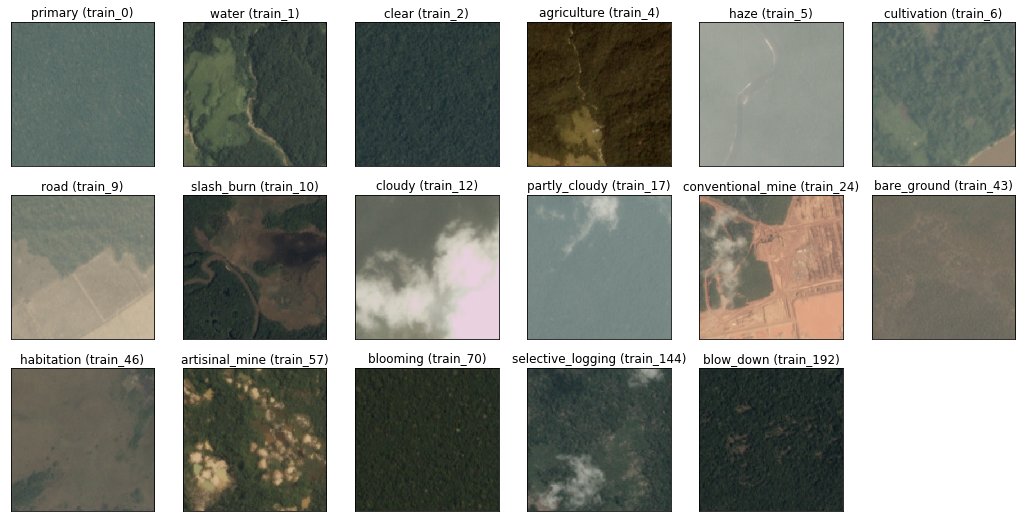

In [4]:
import skimage.io

image_fig = plt.figure(figsize=(18, 9))
example_tags = set()
for sample, tag_list in train_tags.items():
    diff = set(tag_list) - example_tags
    if len(diff) > 0:
        tag = diff.pop()
        example_tags.add(tag)
        image = skimage.io.imread(os.path.join(data_dir, "train-jpg/{}.jpg".format(sample)))
        i = len(example_tags)
        ax = image_fig.add_subplot(3, 6, i)
        ax.set_title("{} ({})".format(tag, sample))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(image)
        if i >= 18 or i == len(train_tags_counts):
            break
plt.show()

A very preliminary observation is that **color** may play an important role is assigning tags to images. For example, *cloudy* clearly contains many white pixels, *primary* contains many green pixels and *habitation* contains many brown pixels. Other tags are more associated with structure and texture, such as *road* and *selective_logging*.